# Cesium 2D+ MOT Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import random

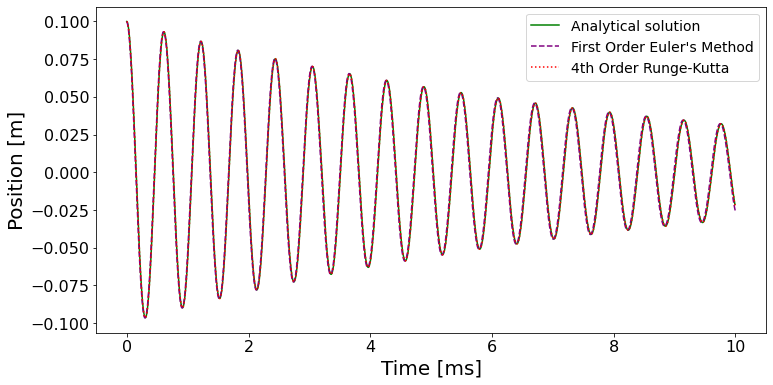

In [2]:
import nbimporter
%run DampedOscillator.ipynb

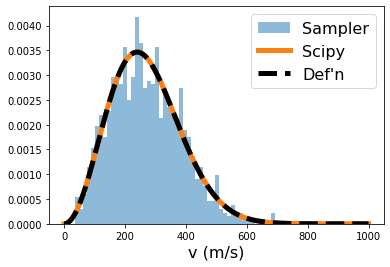

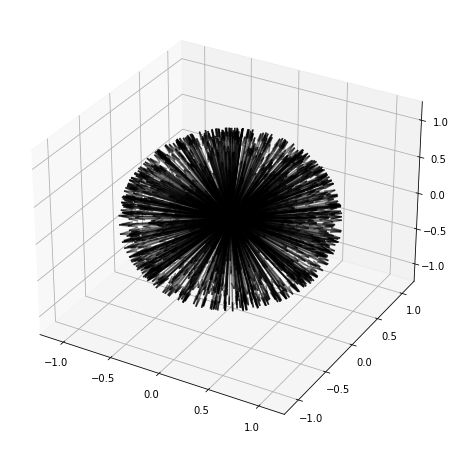

In [3]:
%run MaxwellBoltzmann.ipynb

# Full 2D+ MOT Simulation

In [55]:
# Physical Constants
hbar = 1.055 * 10**(-34) # Js, reduced Planck's constant
light_c = 2.998 * 10**(8) # m/s
BohrMag = 9.27401008 * 10**(-24) # A m^2

# Cesium Specifics
mass = 2.20694695 * 10**(-25) # kg 
gamma = 5.22 * 10**(6) # Hz, natural line width of Cs D2 transition. Lam p. 86.
omega_D2 = 2*np.pi* 351.72571859 * 10**(12) # Hz. Steck p. 15: https://steck.us/alkalidata/cesiumnumbers.1.6.pdf

# Apparatus
tube_diam = 1.5 * 10**(-3) # meters, equal to 1.5mm, differential pumping tube diameter
tube_length = 20 * 10**(-3) # meters, equal to 20mm, differential pumping tube length
bgrad_x = 0.15 # T/m, equal to 12 G/cm.
bgrad_y = bgrad_x
bgrad_z = 0

# Cell dimensions. Will group.
x_len = 0.04 # m
y_len = 0.04 # m
z_len = 0.1  #m

# Distance of 3D MOT volule from tube:
MOT_tube_zrel = .55 # m, equal to 55cm.

# Beams
long_cooling_waist = 34 * 10**(-3) # m. Equal to 8mm. Will Group
short_cooling_waist = 8 * 10**(-3) # m. Equal to 8mm. Will Group.
push_waist = 2.2 * 10**(-3) # m. Equal to 2.2 mm. Circularly symmetric. Page 54 Szulc.

# Optimize
s0_cooling = 23 
s0_push = 3
det_x = -1.9*gamma 
det_y = -1.9*gamma  

det_push = -1.9*gamma
det_counter = -3.5*gamma

0.0007003380230231373
0.00075


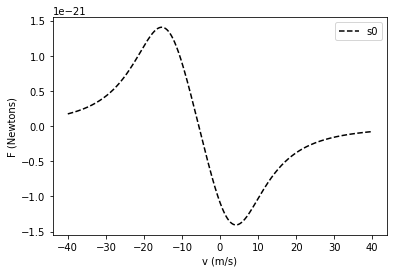

In [92]:
# Check F vs. v profile for this param set.
varr = np.linspace(-40**1, 40**1, 10000)
x = 0.005 # meters

Bx = .001 * magpy.getB(quadcoil, observers=(x*1000,0,0))[0] #Tesla
compare = bgrad_x * x
print(Bx)
print(compare)
plus, minus = getDeltaPM(x, varr, det_x, Bx)

force = radiativeHelper(plus, minus, det_x, s0_cooling)

plt.plot(varr, force, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

## Implementation Info
#### Storage
Positions and velocities of particles are stored as a numpy array of length 3. All functions take in a parameter called axis which must specify "x", "y", or "z". 

#### Geometry
Cooling should occur in the xy plane. 

## Forces

The radiative force takes the form of the following with $e^{-2r^2/w^2}$ representing its Gaussian profile.
$$ \vec{F}_{\pm} =s_0 e^{-2r^2/w^2}\frac{\hbar \gamma/2}{1 + s_0e^{-2r^2/w^2} + (2\Delta_{\pm}/\gamma)^2}\cdot\frac{\omega_{D2} + 2\pi\delta}{c}\hat{k}_{\pm} $$
where for the x-axis, for example:
$$ \Delta_{\pm} = \delta \mp \frac{kv_x}{2\pi} \mp \text{sign}(x)\frac{|\tilde{\mu}B_x(x,y,z)|}{2\pi\hbar}$$
where $\tilde{\mu} = \frac{2}{3}\mu_B$ for the D2 line of Rb-87, and $B_x(x,y,z)$ is the magnetic field x-component at position (x,y,z).

## Functions for the computation of overall detunings and forces

In [8]:
# Overall detuning for counter-push beam.
def getDeltaPlus(x,v,det,Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3

    return Delta_plus

# Overall detuning for push beam.
def getDeltaMinus(x,v,det,Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3

    return Delta_minus

# Get the overall detunings for the push and counterpush beams.
def getDeltaPMpusher(x, v, det_push, det_counter, Bfieldcomp):
    return getDeltaPlus(x,v,det_push, Bfieldcomp), getDeltaMinus(x,v,det_counter, Bfieldcomp)

# Get the overlal detunings for the cooling beams.
def getDeltaPM(x, v, det, Bfieldcomp):
    term1 = det
    term2 = (((omega_D2 + 2*np.pi*det)/(light_c))*v)/(2*np.pi)
    term3 = np.sign(x)*np.abs((2/3)*BohrMag*Bfieldcomp)/(2*np.pi*hbar)
    Delta_plus = term1 - term2 - term3
    Delta_minus = term1 + term2 + term3
    return Delta_plus, Delta_minus

# Helper function for forceRadiative function.
def radiativeHelper(Delta_plus, Delta_minus, det, s_adjusted):
    k = (omega_D2 + 2*np.pi*det)/(light_c)
    F_plus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2)
    F_minus = k * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2)
    return F_plus - F_minus

# Helper function for forcePush function.
def pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adjusted):
    kcounter = (omega_D2 + 2*np.pi*det_push)/(light_c) # counter push
    kpush =  (omega_D2 + 2*np.pi*det_counter)/(light_c) # push 
    F_plus = kpush * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_plus/gamma)**2) #  push
    F_minus = kcounter * (hbar*s_adjusted*(gamma/2))/(1 + s_adjusted + (2*Delta_minus/gamma)**2) # counterpush
    return F_plus, F_minus

# dets = [det_push, det_counter]
def forcePush(x0, v0, dets, Bfieldcomp, s_adj):
    det_push = dets[0]
    det_counter = dets[1]
    # Compute Delta_{pm}. No magnetic field in this direction.
    Delta_plus, Delta_minus = getDeltaPMpusher(x0, v0, det_push, det_counter, Bfieldcomp)
    # Compute Force 
    fplus, fminus = pushHelper(Delta_plus, Delta_minus, det_push, det_counter, s_adj)
    
    # Return push and counterpush
    #return fplus - fminus 
    
    # Return just push
    return fplus

def forceRad(x0, v0, det, Bfieldcomp, s_adj):    
    # Compute Delta_{pm}
    Delta_plus, Delta_minus = getDeltaPM(x0, v0, det, Bfieldcomp)
    # Compute Force
    force = radiativeHelper(Delta_plus, Delta_minus, det, s_adj)
    return force

## Simulation tools (defining a simulation step, RK4 algorithm, etc.)

In [96]:
# One step of 4th Order Runge-Kutte algorithm.
def RK4_step(force, xn, yn, zn, vn, axis, quadcoil, dt, m=mass):
        # Initialize parameters
        det = np.NaN
        #bgrad = np.NaN  # No longer needed due to coils.
        exponent = np.NaN
        s0 = np.NaN
        #Bfieldcomp = np.NaN
        
        # Position variable
        pn = -10e9 # initialize outside of the axis-determination if blocks.
        
        if axis == 0: # x-axis.
            # Adjustment exponent for s0 -> s0e^{-2exponent}:
            exponent = (yn/short_cooling_waist)**2 + (zn/long_cooling_waist)**2
            
            # I/I_{sat}
            s0 = s0_cooling
            
            # Detuning for x:
            det = det_x
            
            # Gradient:
            #bgrad = bgrad_x
            #Bfieldcomp = bgrad_x * xn
            
            
            # Set variable to edit in this RK4 step.
            pn = xn
        elif axis == 1: # y-axis.
            exponent = (xn/short_cooling_waist)**2 + (zn/long_cooling_waist)**2
            s0 = s0_cooling
            det = det_y
            #bgrad = bgrad_y
            #Bfieldcomp = bgrad_y * yn
            pn = yn
        elif axis == 2: # z-axis.
            exponent = (xn/push_waist)**2 + (yn/push_waist)**2
            s0 = s0_push
            det = [det_push, det_counter]
            #bgrad = bgrad_z
            #Bfieldcomp = bgrad_z * zn
            pn = zn
            
        # Make s_adj with the waist:
        s_adj = s0 * np.exp(-2*exponent)
        
        # Get the B-field from the quadcoil. 
        # It comes from magpy in mT, so multiply by 1/1000.
        Bfieldcomp = 0.001 * magpy.getB(quadcoil, observers=(xn* 10**3, yn * 10**3, zn * 10**3))[axis]
        #print("axis = ", axis, "Bfieldcomp = ", Bfieldcomp)
        
        # Make an RK4 STEP.
        K1 = force(pn, vn, det, Bfieldcomp, s_adj)/m
        L1 = vn
        
        K2 = force(pn + dt*L1/2, vn + dt*K1/2, det, Bfieldcomp, s_adj)/m
        L2 = vn + dt*K1/2
        
        K3 = force(pn + dt*L2/2, vn + dt*K2/2, det, Bfieldcomp, s_adj)/m
        L3 = vn + dt*K2/2
        
        K4 = force(pn + dt*L3, vn + dt*K3, det, Bfieldcomp, s_adj)/m
        L4 = vn + dt*K3
        
        # Update xn and vn
        pn = pn + (dt/6)*(L1 + 2*L2 + 2*L3 + L4)
        vn = vn + (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
        
        return pn, vn, K1*m # return force for logging

# One step of the simulation of a particle's trajectory.
# Requires the use of RK4_Step for each direction.
def step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt):
    # Unpack vec_x
    xn, yn, zn = vec_x
    # Unpack vec_v
    vxn, vyn, vzn = vec_v
    
    # Time-evolve
    # x-direction
    xn, vxn, force_x = RK4_step(forceRad, xn, yn, zn, vxn, axis=0, quadcoil=quadcoil, dt=dt)
    # y-direction
    yn, vyn, force_y = RK4_step(forceRad, xn, yn, zn, vyn, axis=1, quadcoil=quadcoil, dt=dt)
    # z-direction
    zn, vzn, force_z = RK4_step(forcePush, xn, yn, zn, vzn, axis=2, quadcoil=quadcoil, dt=dt)
    
    return np.array([xn, yn, zn]), np.array([vxn, vyn, vzn]), np.array([force_x, force_y, force_z])
    
# Simulate a particle's trajectory for a given amount of time.
# Initial position and velocity vectors: vec_x, vec_v
def simulate(vec_x, vec_v, quadcoil, dt=10 * 10**(-6), num_timesteps=1000000, m=mass):
    # Storage
    positions = []
    positions.append(np.copy(vec_x))
    velocities = []
    velocities.append(np.copy(vec_v))
    times = []
    times.append(0)
    forces = []
    
    # Flag for success. 1 =  True. 0 = False.
    success = 0 # Initialize to 0 if one wants onnly the atoms that reach science chamber.
                # Initialize to 1 if one wants atoms that did not collide with wall AND science chamber atoms
    
    for j in range(0, num_timesteps):
        vec_x, vec_v, vec_force = step(forceRad, forcePush, vec_x, vec_v, quadcoil, dt)    
        positions.append(np.copy(vec_x))
        velocities.append(np.copy(vec_v))
        times.append((j+1) * dt)
        forces.append(np.copy(vec_force))
        
        if aboveCell(vec_x):
            if checkTubeCollision(vec_x):
                success=0
                break
            else: # if in tube and no collision, check if reached science chamber.
                if reachedScienceChamber(vec_x):
                    success=1
                    break
                    
        elif checkCollision(vec_x): # If it's not in the tube, it checks for cell collision.
            success=0
            break
        
    return np.array(positions), np.array(velocities), np.array(times), np.array(forces), success

### Boundary checks (collisions, reach science chamber, reach 3DMOT volume etc.)

In [97]:
# Return true if science chamber z (z_len/2 + tube_length) is acquired
def reachedScienceChamber(vec_x):
    x, y, z = vec_x
    if z > ((z_len/2) + tube_length):
        return True

# Return true if its above the cell.
def aboveCell(vec_x):
    x, y, z = vec_x
    if z > z_len/2:
        return True

# Assumption is that it the atom is in the tube (above cell)
def checkTubeCollision(vec_x):
    x, y, z = vec_x
    # Check collision in tube:
    if np.sqrt(x**2 + y**2) > tube_diam/2:
        return True 

# Return true if collision within the cell.
def checkCollision(vec_x):
    x, y, z = vec_x
    # It's in the cell, check for collisions.
    if np.abs(x) > x_len/2 or np.abs(y) > y_len/2 or z < -z_len/2:
        return True
    else:
        return False

# Returns true if in 3D MOT volume

## Simulation Cell 1: Sanity check -- all atoms initialized at the origin.

In [98]:
N_sim = 100000
print("Simulating the trajectories of", N_sim, "atoms...")

# Should a cut velocity be activated?
# This means no trajectory is simulated with initial v_samp > v_cut.
ActivateCutVelocity = False
vcut = 100 #m/s

# Data storage
pos_rec = []
vel_rec = []
times_rec = []
forces_rec = []
successes = 0
success_index = []

# Loop to simulate N_sim trajectories
for n in range(0, N_sim):
    # Sample a velocity vector from MBD
    smp = sampleVelocityVec()
    
    # Find a velocity vector below the cut, if requested.
    if ActivateCutVelocity:
        while np.linalg.norm(smp) > vcut:
            smp = sampleVelocityVec()
    
    # Initialize atom
    vec_x = np.array([0,0,0])
    vec_v = np.array([smp[0], smp[1], smp[2]]) # Sampled v from Maxwell-Boltzmann
    
    # Simulate the atom's trajectory
    pos, vel, times, forces, success = simulate(vec_x, vec_v, quadcoil, num_timesteps=1000000)
    
    # TO DO: use the remaining num_timesteps to run another atom. 
    # So do a while remaining_timesteps > 1, keep simulating.
    # Probably don't change this cell, just make a new Sim cell.
    
    # Save data.
    if success == 1:
        successes += 1
        success_index.append(n)
        print("Success at n = ", n)
    pos_rec.append(pos)
    vel_rec.append(vel)
    forces_rec.append(forces)
    times_rec.append(times)
    
    # Update user with progress
    if n % int(N_sim/100) == 0:
        print("Done with run ", n)

print("Successful: ", successes)
print("Success index: ", success_index)

Simulating the trajectories of 100000 atoms...
Done with run  0
Done with run  1000
Done with run  2000
Done with run  3000
Done with run  4000
Done with run  5000
Done with run  6000
Success at n =  6136
Done with run  7000
Done with run  8000
Done with run  9000
Success at n =  9248
Done with run  10000
Done with run  11000
Done with run  12000
Success at n =  12655
Done with run  13000
Success at n =  13260
Done with run  14000
Done with run  15000
Done with run  16000
Done with run  17000
Success at n =  17059
Done with run  18000
Done with run  19000
Done with run  20000
Done with run  21000
Success at n =  21880
Done with run  22000
Done with run  23000
Success at n =  23285
Done with run  24000
Done with run  25000
Done with run  26000
Success at n =  26713
Done with run  27000
Done with run  28000
Done with run  29000
Done with run  30000
Success at n =  30893
Done with run  31000
Done with run  32000
Done with run  33000
Done with run  34000
Done with run  35000
Done with run 

## Simulation Cell 2: Flux computation.  
Atoms have randomized initial positions in the cell, replacement upon escape or collision.

In [27]:
def getRandomX():
    return np.array([np.random.uniform(-x_len/2, x_len/2),np.random.uniform(-y_len/2, y_len/2), np.random.uniform(-z_len/2, z_len/2) ])

In [26]:
# For ideal gas, PV/kT = N. For Szulc's simulation he assumes 10^(-7) mbar for the pressure.
# Assuming room temperature and the volume 4cm*4cm*10cm:
N_real = 3.863 * 10**(11)

###################
#  Start the sim  #
###################
N_sim = 100000

# Should a cut velocity be activated?
# This means no trajectory is simulated with initial v_samp > v_cut.
ActivateCutVelocity = False
vcut = 100 #m/s

# Data storage
pos_rec = []
vel_rec = []
times_rec = []
forces_rec = []
successes = 0
success_index = []

# Loop to simulate N_sim trajectories
for n in range(0, N_sim):
    # Sample a velocity vector from MBD
    smp = sampleVelocityVec()
    
    # Find a velocity vector below the cut, if requested.
    if ActivateCutVelocity:
        while np.linalg.norm(smp) > vcut:
            smp = sampleVelocityVec()
    
    # Initialize atom
    vec_x = getRandomX()
    vec_v = np.array([smp[0], smp[1], smp[2]]) # Sampled v from Maxwell-Boltzmann
    
    # Simulate the atom's trajectory
    pos, vel, times, forces, success = simulate(vec_x, vec_v, num_timesteps=1000000)
    
    # TO DO: use the remaining num_timesteps to run another atom. 
    # So do a while remaining_timesteps > 1, keep simulating.
    # Probably don't change this cell, just make a new Sim cell.
    
    # Save data.
    if success == 1:
        successes += 1
        success_index.append(n)
        print("Success at n = ", n)
    pos_rec.append(pos)
    vel_rec.append(vel)
    forces_rec.append(forces)
    times_rec.append(times)
    
    # Update user with progress
    if n % int(N_sim/100) == 0:
        print("Done with run ", n)

print("Successful: ", successes)
print("Success index: ", success_index)
#flux = "{:e}".format.((successes/N_sim) * N_real)
#print("(not exact) Flux: ", flux )

NameError: name 'getRandomX' is not defined

### Looking at one science chamber atom's trajectory:

Initial velocity:  [ 3.21970479 -7.9476942  -8.31217571]


Text(0, 0.5, 'F_z (N)')

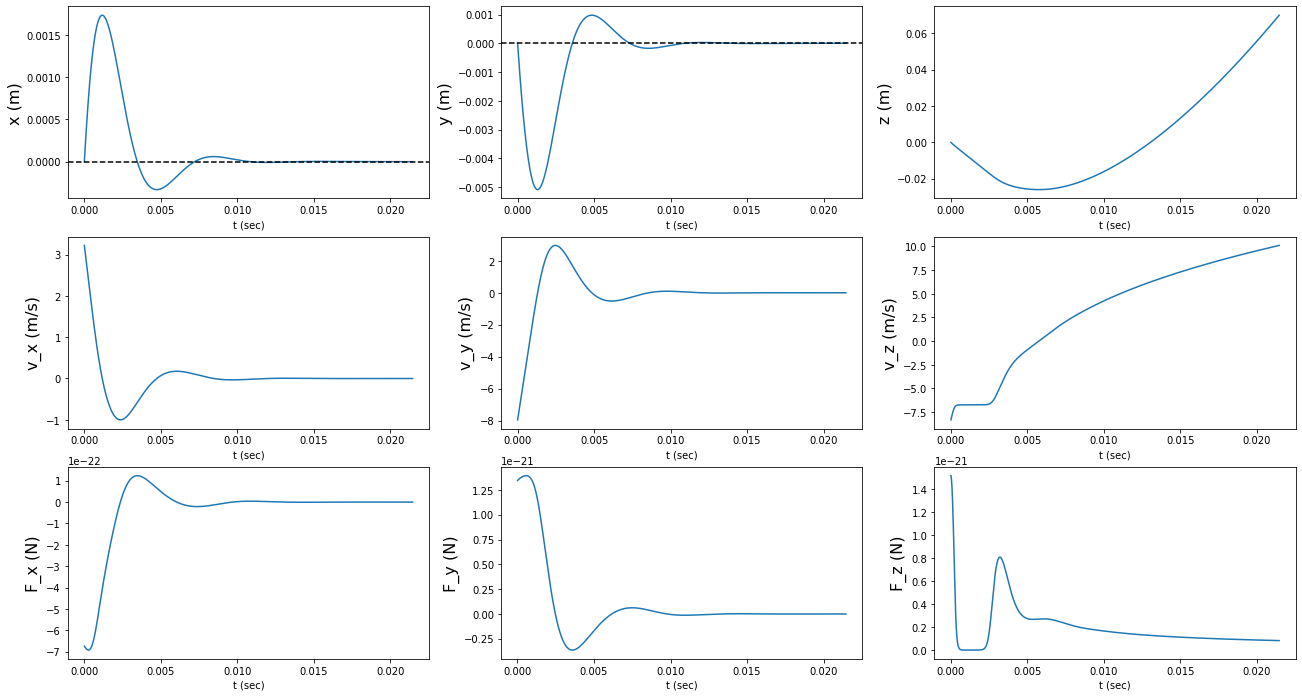

In [100]:
# positions
fig, ax = plt.subplots(3, 3, figsize=(22, 12))

sim = True
if sim:
    nnn=success_index[1]
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    print("Initial velocity: ", vel[0])
    forces = forces_rec[nnn]
    times = times_rec[nnn]

# x-pos (TOP LEFT)
ax[0,0].plot(times, pos[:, 0], label="RK4")
ax[0,0].axhline(0, ls="--", c="black")
ax[0,0].set_xlabel("t (sec)")
ax[0,0].set_ylabel("x (m)", fontsize=16)

# v_x (middle LEFT)
ax[1,0].plot(times, vel[:, 0], label="RK4")
ax[1,0].set_xlabel("t (sec)")
ax[1,0].set_ylabel("v_x (m/s)", fontsize=16)

# F_x (bottom LEFT)
ax[2,0].plot(times[1:], forces[:, 0], label="RK4")
ax[2,0].set_xlabel("t (sec)")
ax[2,0].set_ylabel("F_x (N)", fontsize=16)

# y-pos (TOP CENTER)
ax[0, 1].plot(times, pos[:, 1], label="RK4")
ax[0, 1].axhline(0, ls="--", c="black")
ax[0, 1].set_xlabel("t (sec)")
ax[0, 1].set_ylabel("y (m)", fontsize=16)

# v_y (BOTTOM CENTER)
ax[1, 1].plot(times, vel[:, 1], label="RK4")
ax[1, 1].set_xlabel("t (sec)")
ax[1, 1].set_ylabel("v_y (m/s)", fontsize=16)

# F_y (bottom middle)
ax[2,1].plot(times[1:], forces[:, 1], label="RK4")
ax[2,1].set_xlabel("t (sec)")
ax[2,1].set_ylabel("F_y (N)", fontsize=16)


# z-pos (TOP RIGHT)
ax[0, 2].plot(times, pos[:, 2], label="RK4")
ax[0, 2].set_xlabel("t (sec)")
ax[0, 2].set_ylabel("z (m)", fontsize=16)

# v_z (BOTTOM RIGHT)
ax[1, 2].plot(times, vel[:, 2], label="RK4")
ax[1, 2].set_xlabel("t (sec)")
ax[1, 2].set_ylabel("v_z (m/s)", fontsize=16)

# F_z (bottom middle)
ax[2,2].plot(times[1:], forces[:, 2], label="RK4")
ax[2,2].set_xlabel("t (sec)")
ax[2,2].set_ylabel("F_z (N)", fontsize=16)

### The initial and exit velocities of atoms that reach the science chamber

Text(0.5, 0, 'Exit $v_z$ (m/s)')

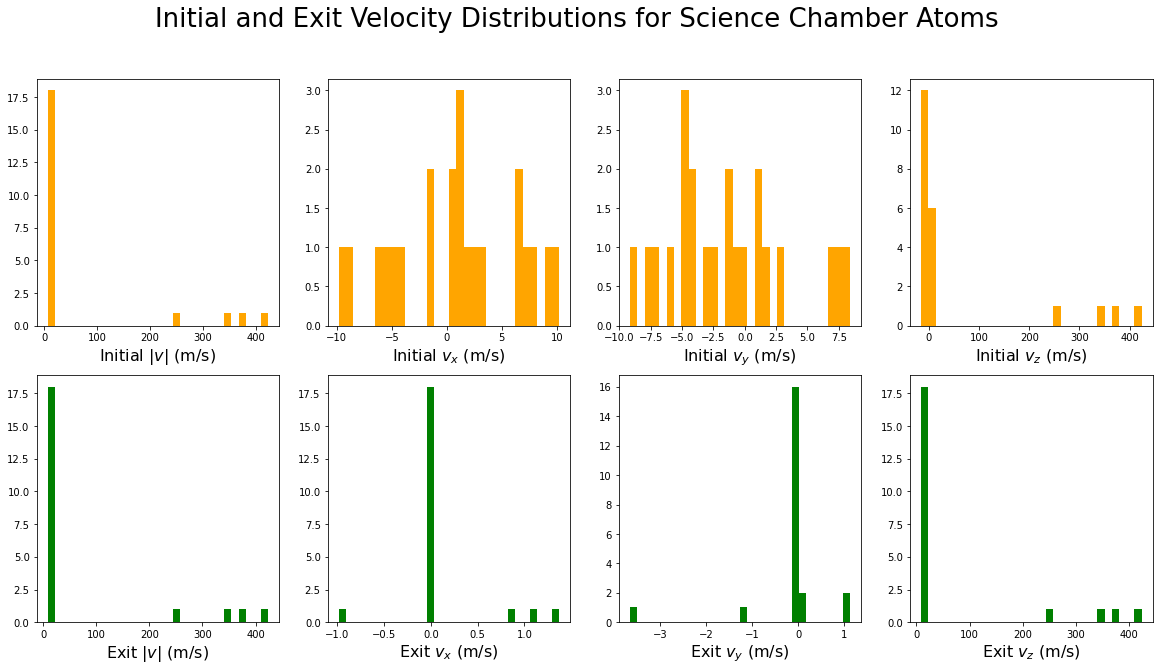

In [101]:
# Make a histogram of the trapped speeds
speeds = []
vxs = []
vys = []
vzs = []

# Exit
espeeds = []
evxs = [] 
evys = []
evzs = []

for n in success_index:
    # Collect initial velocities
    vel = vel_rec[n][0]
    spd = np.sqrt(np.sum(vel**2))
    speeds.append(spd)
    vxs.append(vel[0])
    vys.append(vel[1])
    vzs.append(vel[2])
    
    # Collect exit velocities
    vel = vel_rec[n][-1]
    espd = np.sqrt(np.sum(vel**2))
    espeeds.append(espd)
    evxs.append(vel[0])
    evys.append(vel[1])
    evzs.append(vel[2])
    
# Plotting:
fig, ax = plt.subplots(2,4, figsize=(20,10))
fig.suptitle("Initial and Exit Velocity Distributions for Science Chamber Atoms", fontsize=26)


# Initial
ax[0][0].hist(speeds, bins=30, label="speed", color="orange")
ax[0][0].set_xlabel(r"Initial $|v|$ (m/s)", fontsize=16)

ax[0][1].hist(vxs, bins=30, label="vx", color="orange")
ax[0][1].set_xlabel(r"Initial $v_x$ (m/s)", fontsize=16)

ax[0][2].hist(vys, bins=30, label="vy", color="orange")
ax[0][2].set_xlabel(r"Initial $v_y$ (m/s)", fontsize=16)

ax[0][3].hist(vzs, bins=30, label="vz", color="orange")
ax[0][3].set_xlabel(r"Initial $v_z$ (m/s)", fontsize=16)

# Exit
ax[1][0].hist(espeeds, bins=30, label="speed", color="green")
ax[1][0].set_xlabel(r"Exit $|v|$ (m/s)", fontsize=16)

ax[1][1].hist(evxs, bins=30, label="vx", color="green")
ax[1][1].set_xlabel(r"Exit $v_x$ (m/s)", fontsize=16)

ax[1][2].hist(evys, bins=30, label="vy", color="green")
ax[1][2].set_xlabel(r"Exit $v_y$ (m/s)", fontsize=16)

ax[1][3].hist(evzs, bins=30, label="vz", color="green")
ax[1][3].set_xlabel(r"Exit $v_z$ (m/s)", fontsize=16)

### Visualizing the trajectories of atoms that made it to the science chamber

Text(0.5, 0, 'z (m)')

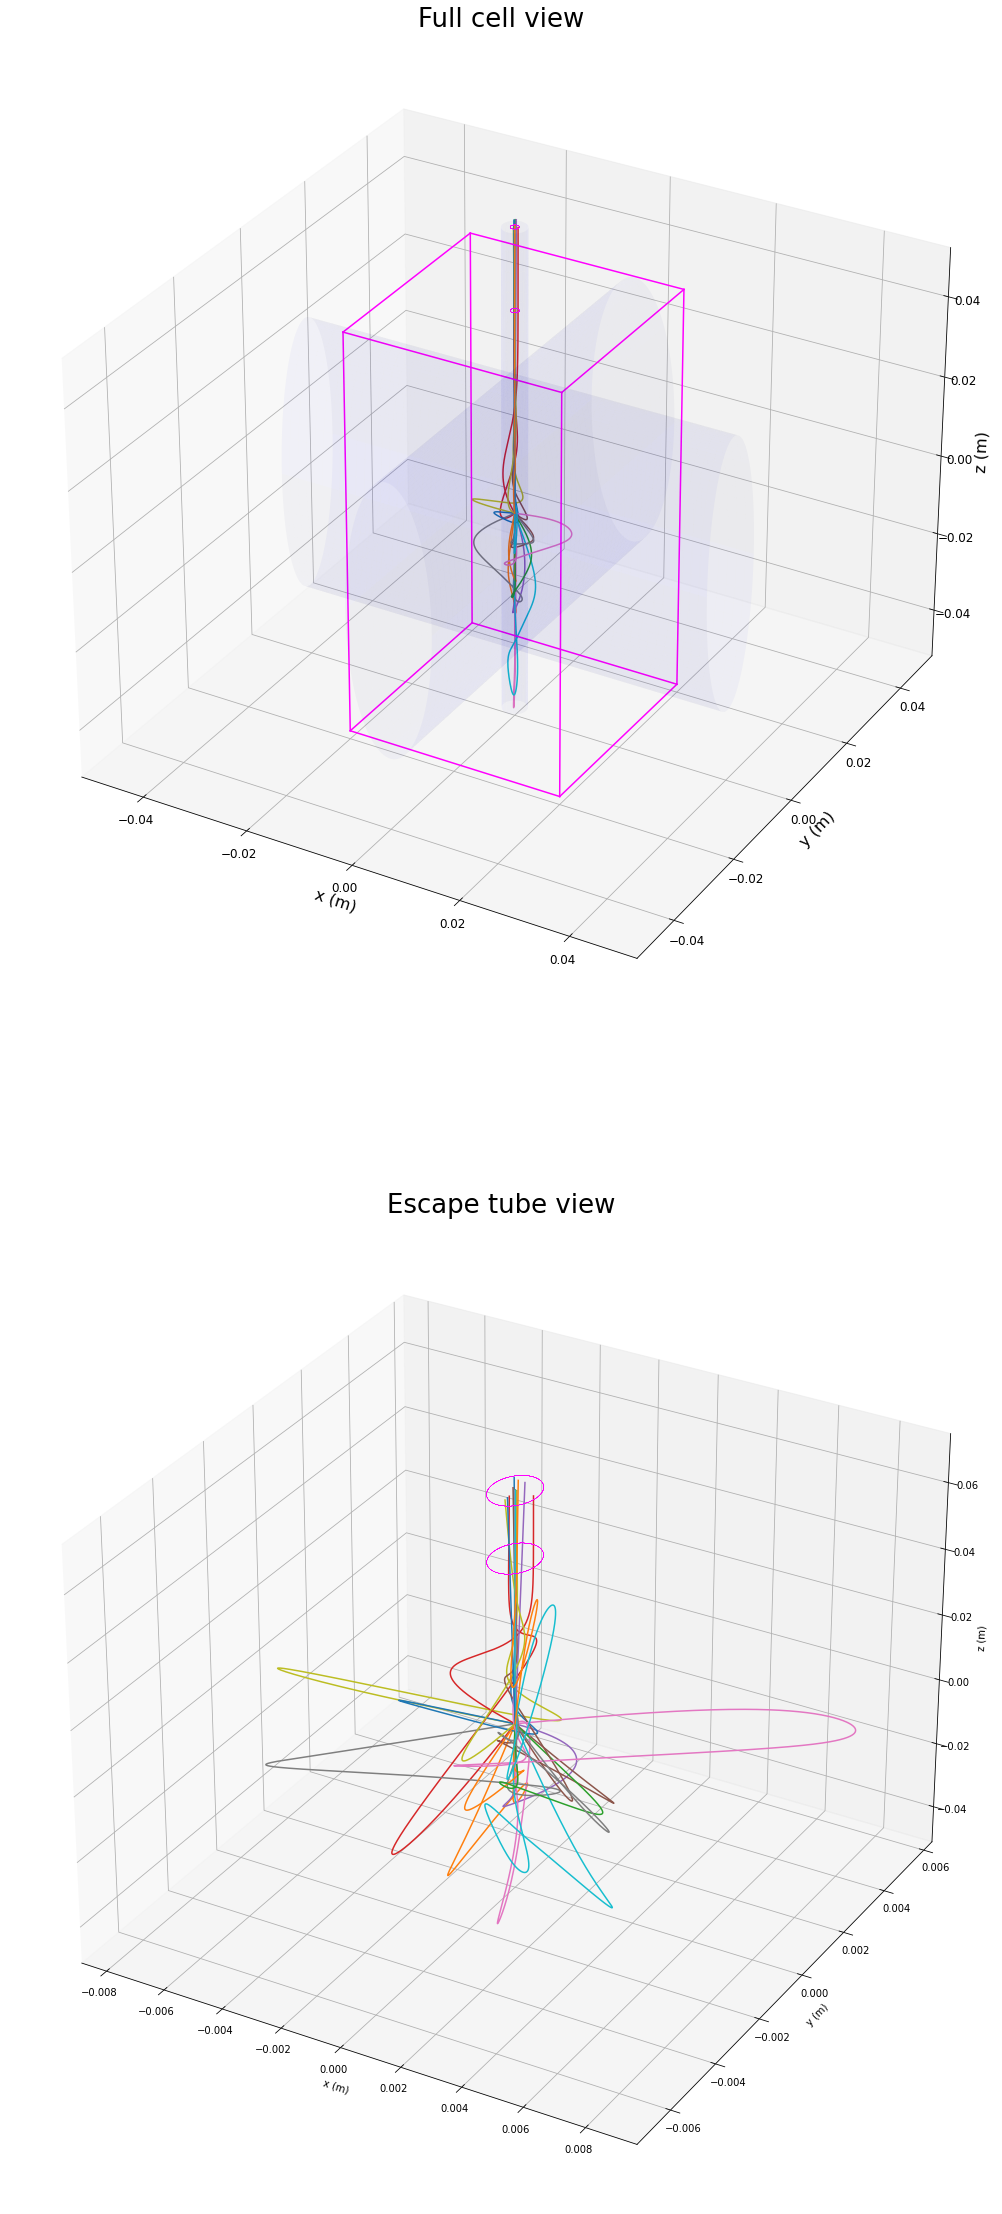

In [103]:
fig = plt.figure(figsize=(20,40)) 
ax = fig.add_subplot(211, projection='3d')
ax.set_xlabel("x (m)", fontsize=16)
ax.set_ylabel("y (m)", fontsize=16)
ax.set_zlabel("z (m)", fontsize=16)
ax.set_title("Full cell view", fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=12)

show = True
successfulOnly = True
plotAll = True # otherwise plotN:
plotN = 15
if show:
    if successfulOnly:
        if plotAll:
            for n in success_index:
                pos = pos_rec[n]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        else:
            for i in range(plotN):
                pos = pos_rec[success_index[i]]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    else:
        for i in range(0, plotN):
            pos = pos_rec[random.randint(0, N_sim-1)]
            ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

#  [95, 191, 316, 436, 478, 616, 987]
sim = False
if sim:
    nnn = success_index[0] # Plot this index
    pos = pos_rec[nnn]
    vel = vel_rec[nnn]
    forces = forces_rec[nnn]
    times = times_rec[nnn]
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    
    
# Build beams:
showBeams = True
if showBeams:
    alpha = 0.03
    # Cylinder | https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
    xcyl = np.linspace(-push_waist, push_waist, 1000)
    zcyl = np.linspace(-z_len/2, tube_length + z_len/2, 1000)
    Xc, Zc = np.meshgrid(xcyl, zcyl)
    Yc = np.sqrt(push_waist**2-Xc**2)
    ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
    ax.plot_surface(Xc, -Yc, Zc, alpha=alpha, color="blue")
    
    xcyl = np.linspace(-short_cooling_waist, short_cooling_waist, 1000)
    ycyl = np.linspace(-y_len, y_len, 1000) 
    Xc, Yc = np.meshgrid(xcyl, ycyl)
    Zc = np.sqrt(long_cooling_waist**2 * (1 - Xc**2/short_cooling_waist**2))
    ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
    ax.plot_surface(Xc, Yc, -Zc, alpha=alpha, color="blue")
    
    ycyl = np.linspace(-short_cooling_waist, short_cooling_waist, 1000)
    xcyl = np.linspace(-x_len, x_len, 1000) 
    Xc, Yc = np.meshgrid(xcyl, ycyl)
    Zc = np.sqrt(long_cooling_waist**2 * (1 - Yc**2/short_cooling_waist**2))
    ax.plot_surface(Xc, Yc, Zc, alpha=alpha, color="blue")
    ax.plot_surface(Xc, Yc, -Zc, alpha=alpha, color="blue")
        
# Build cell:
showCell = True
showTube = True

if showCell:
    ls = "-"
    col="magenta"
    cell_x = np.linspace(-x_len/2, x_len/2, 1000)
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    cell_y = np.linspace(-y_len/2, y_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c=col,ls=ls)
    ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c=col, ls=ls)
    ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c=col,ls=ls)
    cell_z = np.linspace(-z_len/2, z_len/2, 1000)
    ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)
    ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c=col,ls=ls)
    ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)
    ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c=col, ls=ls)

    
    # Set limits for first plot
    limm = 0.5*z_len
    ax.set_xlim(-limm, limm)
    ax.set_ylim(-limm, limm)
    ax.set_zlim(-limm, limm)


# Build hole
if showTube:
    # Tube left fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    # Plot:
    if show:
        if successfulOnly:
            if plotAll:
                for n in success_index:
                    pos = pos_rec[n]
                    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
            else:
                for i in range(plotN):
                    pos = pos_rec[success_index[i]]
                    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
        else:
            plotN = 10
            for i in range(0, plotN):
                pos = pos_rec[random.randint(0, N_sim-1)]
                ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])
    if sim:
        pos = pos_rec[nnn]
        vel = vel_rec[nnn]
        forces = forces_rec[nnn]
        times = times_rec[nnn]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    # Tube right fig
    uuu = np.linspace(0, 100, 10000)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2, c="magenta", lw=0.1)
    ax.plot((tube_diam/2)*np.cos(uuu), (tube_diam/2)*np.sin(uuu), z_len/2 + tube_length, c="magenta", lw=0.1)
    
    tubeCenter = False
    if tubeCenter:
        ax.set_xlim(-0.007*z_len, 0.007*z_len)
        ax.set_ylim(-0.007*z_len, 0.007*z_len)
        ax.set_zlim(-0.007*z_len, 0.007*z_len)

ax.set_title("Escape tube view", fontsize=26)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

## Import our B-field

Collection nolabel (id=140455798534544)
├── Loop nolabel (id=140455798537872)
├── Loop nolabel (id=140455798535504)
├── Loop nolabel (id=140455798536592)
└── Loop nolabel (id=140455798536720)


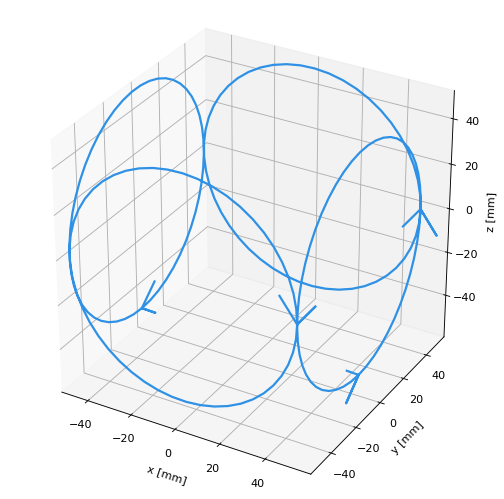

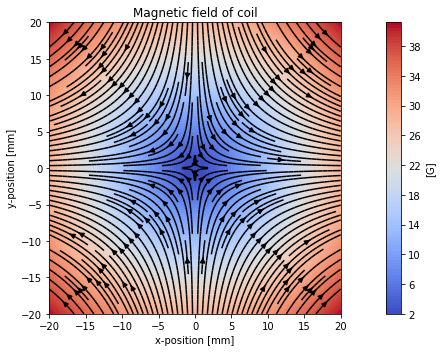

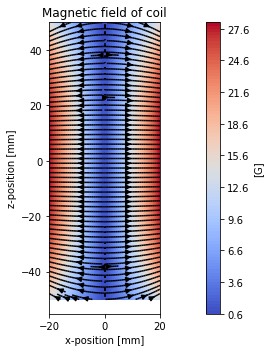

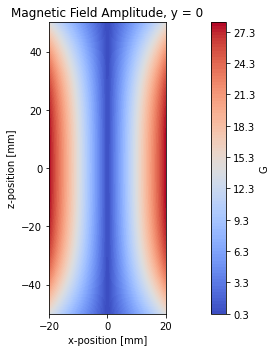

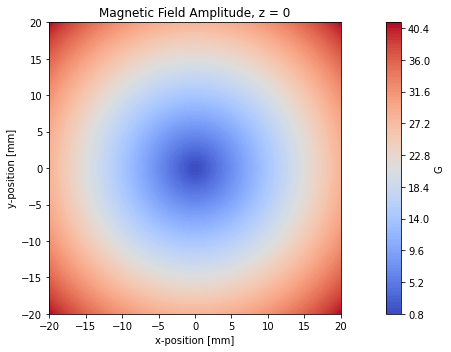

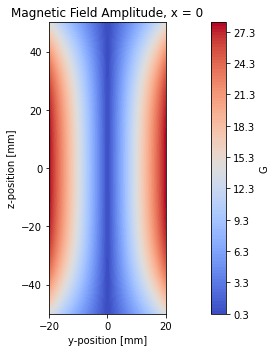

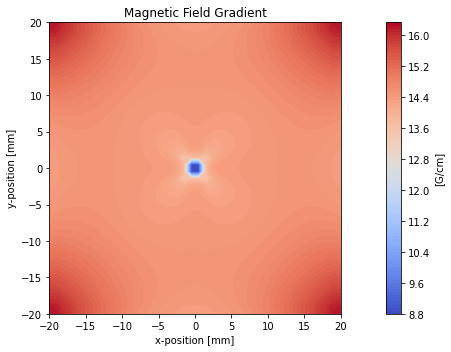

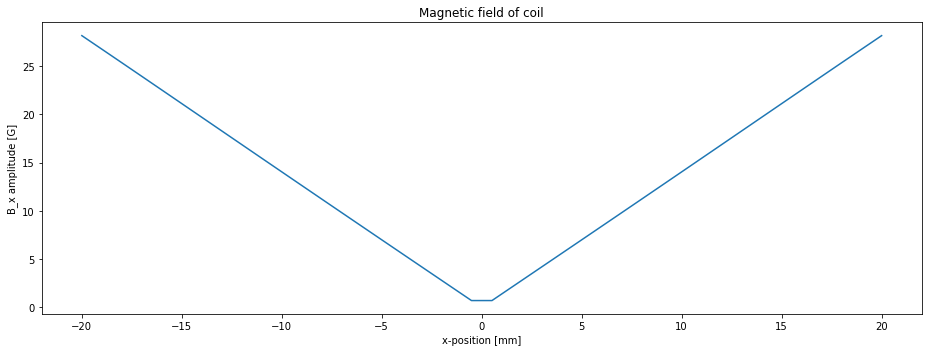

In [66]:
%run CoilCreator.ipynb

In [67]:
# Magpy collection to use for simulation is now "quadcoil"
quadcoil

Collection(id=140455798534544)

### Random scratch work.

In [ ]:
# Proof that pushHelper works.
varr = np.linspace(-40, 40, 10000)
x = 0
s00 = s0

plus, minus = getDeltaPMpusher(x, varr, det_push, det_counter, 0)

fplus, fminus = pushHelper(plus, minus, det_push, det_counter, s00)

plt.plot(varr, fplus, label="s0", ls="--", c="k")
plt.xlabel("v (m/s)")
plt.ylabel("F (Newtons)")
plt.legend()

In [ ]:
# Checking my random vec_x generator works

vecs = []
for dummy in range(1000):
    vecs.append(getRandomX())
vecs = np.array(vecs)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Random points
ax.scatter(vecs[:,0], vecs[:,1], vecs[:,2])

# Cell
cell_x = np.linspace(-x_len/2, x_len/2, 1000)
ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, (y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(cell_x, -(y_len/2)*np.ones_like(cell_x), -(z_len/2)*np.ones_like(cell_x), c="magenta")
cell_y = np.linspace(-y_len/2, y_len/2, 1000)
ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot((x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot(-(x_len/2)*np.ones_like(cell_x), cell_y, (z_len/2)*np.ones_like(cell_x), c="magenta")
ax.plot((-x_len/2)*np.ones_like(cell_x), cell_y, -(z_len/2)*np.ones_like(cell_x), c="magenta")
cell_z = np.linspace(-z_len/2, z_len/2, 1000)
ax.plot((x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot((x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot(-(x_len/2)*np.ones_like(cell_x), (y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")
ax.plot((-x_len/2)*np.ones_like(cell_x), -(y_len/2)*np.ones_like(cell_x), cell_z, c="magenta")

plt.show()